## Breast Cancer Classification - BUSI dataset

## Import Library

In [1]:
#import library
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

# Data Split - 70:15:15

In [ ]:
#SKIP 
import os
#Crate folder data split 
def create_data_split():
    #Base directory 
    base_dir = 'data_split'
    os.makedirs(base_dir, exist_ok=True)

    #Directories for train, test, and validation
    train_dir = base_dir + '/train'
    test_dir = base_dir + '/test'
    val_dir = base_dir + '/val'
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    #class 
    classes = ['malignant', 'benign', 'normal']
    for class_name in  classes:
        os.makedirs(os.path.join(train_dir, class_name))
        os.makedirs(os.path.join(test_dir, class_name))
        os.makedirs(os.path.join(val_dir, class_name))
    
    return train_dir, test_dir, val_dir


In [ ]:
import glob
import shutil
from sklearn.model_selection import train_test_split

def split(source_path='Dataset_BUSI_with_GT', train_ratio=0.7, test_ratio=0.15, val_ratio=0.15): 
    train_dir, test_dir, val_dir = create_data_split()
    classes = ['malignant', 'benign', 'normal']
    
    for class_name in classes:
        class_path = os.path.join(source_path, class_name)
        all_file = [f for f in glob.glob(os.path.join(class_path, '*.png')) 
                    if not f.endswith('_mask.png') and not f.endswith('_mask_1.png')]

        train_files, val_files = train_test_split(all_file, train_size=train_ratio)
        val_files, test_files = train_test_split(val_files, test_size=val_ratio/(val_ratio + test_ratio))

        for f in train_files:
            shutil.copy2(f, os.path.join(train_dir, class_name, os.path.basename(f)))
        for f in val_files:
            shutil.copy2(f, os.path.join(val_dir, class_name, os.path.basename(f)))
        for f in test_files:
            shutil.copy2(f, os.path.join(test_dir, class_name, os.path.basename(f)))

        print(f"Class: {class_name}")
        print(f"Total files: {len(all_file)}")
        print(f"Training files: {len(train_files)}")
        print(f"Validation files: {len(val_files)}")
        print(f"Test files: {len(test_files)}\n")

    return train_dir, test_dir, val_dir

# Call split function
train_dir, test_dir, val_dir = split(source_path='Dataset_BUSI_with_GT', train_ratio=0.7, test_ratio=0.15, val_ratio=0.15)
 

Class: malignant
Total files: 210
Training files: 147
Validation files: 31
Test files: 32

Class: benign
Total files: 438
Training files: 306
Validation files: 66
Test files: 66

Class: normal
Total files: 133
Training files: 93
Validation files: 20
Test files: 20



# Set Device - used GPU for compute

In [2]:
# Set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} (GPU: {torch.cuda.is_available()})")

Using device: cuda (GPU: True)


# Config Basic parameters

In [3]:
#Config parameters
data_dir = 'data_split'
train_dir = ('data_split/train')
test_dir = ('data_split/test')
val_dir = ('data_split/val')

batch_size = 32
num_classes = 3
Epochs = 80
img_size = (224, 224)
learning_rate = 0.001

# Class weight 'balance'-  data imbalance

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import os 
#Class weights calculation 
# Collect labels for training data
train_labels = []
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for img in os.listdir(class_path):
        train_labels.append(class_name)

print("Training labels:", train_labels)
print("Total Label",len(train_labels))
print("Class begin Label",(train_labels.count('benign')))
print("Class normal Label",(train_labels.count('normal')))
print("Class malignant Label",(train_labels.count('malignant')))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# # Convert class weights to a tensor
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", weights)

Training labels: ['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'b

# Data Augmentation

In [5]:
# *ToTenser = shape (C x H x W) in the range [0.0, 1.0] 
from torchvision import transforms

transforms_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Normalization of ImageNet
#make data normalization rang [0, 1], model easy to learn. decrease problem: parameters bigger or smaller than 1, model hard to learn 
])

# # Enhancement Data Augmentation
# transforms_train = transforms.Compose([
#     transforms.Resize(img_size),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.3),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                        std=[0.229, 0.224, 0.225])
# ])

transforms_val = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transforms_val)
test_dataset = datasets.ImageFolder(test_dir, transform=transforms_val)

# Print dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}
print(f"Dataset sizes: {dataset_sizes}")

#Compress data
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2,)   
}

Dataset sizes: {'train': 546, 'val': 117, 'test': 118}


# Dynamic sampling - oversampling minority class 
(ทำให้โมเดลเห็นเซ็ทที่มีข้อมูลน้อยบ่อยขึ้น)

In [6]:
## ADDING --  Dynamic sampling weights for oversampling minority classes (malignant)
from torch.utils.data import WeightedRandomSampler
def get_dynamic_sampler(dataset):
    # Count samples per class
    targets = np.array(dataset.targets)
    class_sample_count = np.array([np.sum(targets == t) for t in np.unique(targets)])
    # Inverse frequency for each class
    weight = 1. / class_sample_count
    # Assign weight to each sample
    samples_weight = np.array([weight[t] for t in targets])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    return sampler


dataloaders['train'] = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=get_dynamic_sampler(train_dataset), num_workers=2
)

print(dataloaders['train']) 
# Check if the dataloaders are working
for phase in ['train', 'val', 'test']:
    print(f"{phase.capitalize()} DataLoader:")
    for images, labels in dataloaders[phase]:
        print(f"  Batch size: {images.size(0)}, Labels(first batch): {labels}")
        break  
  

Train DataLoader:
  Batch size: 32, Labels(first batch): tensor([1, 1, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 0,
        0, 2, 2, 2, 0, 0, 1, 2])
Val DataLoader:
  Batch size: 32, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Test DataLoader:
  Batch size: 32, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


# Get single batch - get from dataloader [Test]

Batch Shape: torch.Size([32, 3, 224, 224])
Data Type: torch.float32
Min: -2.1179039478302, Max: 2.640000104904175
Mean: -0.5172, Std: 1.0342
Number of batches in each split:
- Train: 18
- Val: 4
- Test: 4
Class to Index Mapping:
{'benign': 0, 'malignant': 1, 'normal': 2}

Class Names (in order of indices):
['benign', 'malignant', 'normal']

Samples per class:
benign: 306 images
malignant: 147 images
normal: 93 images
Image stats - Min: 0.003, Max: 0.981, Mean: 0.234
Image stats - Min: 0.013, Max: 0.939, Mean: 0.217
Image stats - Min: 0.000, Max: 0.972, Mean: 0.224
Image stats - Min: 0.003, Max: 0.995, Mean: 0.278
Image stats - Min: 0.000, Max: 0.801, Mean: 0.136


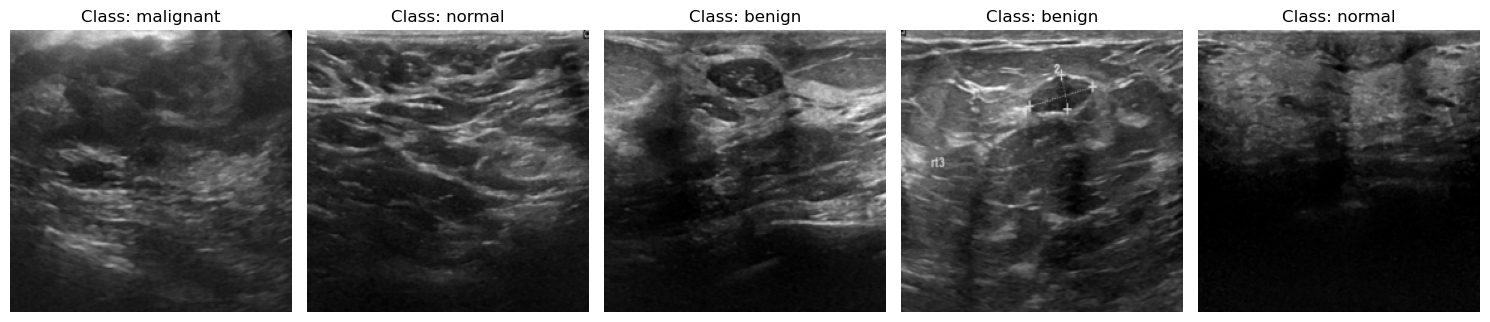

In [7]:
# Get a single batch from the DataLoader
train_batch, train_labels = next(iter(dataloaders['train']))  # Fetch first batch and labels

# Print batch information
print(f"Batch Shape: {train_batch.shape}")
print(f"Data Type: {train_batch.dtype}")
print(f"Min: {train_batch.min()}, Max: {train_batch.max()}")
print(f"Mean: {train_batch.mean():.4f}, Std: {train_batch.std():.4f}")
print(f"Number of batches in each split:")
print(f"- Train: {len(dataloaders['train'])}")
print(f"- Val: {len(dataloaders['val'])}")
print(f"- Test: {len(dataloaders['test'])}")

# Print class mapping
print("Class to Index Mapping:")
print(train_dataset.class_to_idx)

# Print class names in order
print("\nClass Names (in order of indices):")
print(train_dataset.classes)

# Count samples per class
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset:
    class_counts[train_dataset.classes[label]] += 1

print("\nSamples per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

def visualize_batch(dataloader, num_images=5):
    # Get batch of images and labels
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Get class names from the dataset
    class_names = dataloader.dataset.classes
    
    # Create a figure with subplots and show images
    plt.figure(figsize=(15, 4))
    
    for i in range(num_images):
        # Convert tensor to numpy and transpose to (H,W,C)
        img = images[i].numpy().transpose(1, 2, 0)
        
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        gamma = 1.2
        img = np.power(img, gamma)
        print(f"Image stats - Min: {img.min():.3f}, Max: {img.max():.3f}, Mean: {img.mean():.3f}")
        # Create subplot
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'Class: {class_names[labels[i]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a batch of images
visualize_batch(dataloaders['train'])


# Model setup

In [8]:
from torchvision.models import resnet50 ,ResNet50_Weights
#1. Define model
def setup_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Modify final layer for 3-class problem
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)  
        # nn.Softmax(dim=1)  #Softmax for multi-class classification
        # nn.Linear(in_features, 3) #Maps features to 3 output logits
        # nn.LogSoftmax(dim=1)  # LogSoftmax for multi-class classification (if using CrossEntropyLoss, this is not needed during training, but can be used during inference
    )
    
    return model.to(device)

model = setup_model()

print(model)
print(f"Number of layers in ResNet50: {len(list(model.children()))}")
print(f'Total parameters : {sum(p.numel() for p in model.parameters())}')
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
#Focal Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    This is a more robust and complete implementation of Focal Loss.
    It handles multi-class cases and the alpha parameter correctly.
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean',):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: model predictions of shape [N, C]
        # targets: ground truth of shape [N]
        
        # First, compute the raw cross-entropy loss without any reduction
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Then, compute the probability of the correct class (p_t)
        # pt = exp(-ce_loss)
        pt = torch.exp(-ce_loss)
        
        # This is the core of Focal Loss.
        # It computes the modulating factor (1 - pt)^gamma
        # and multiplies it with the cross-entropy loss.
        focal_loss = (1 - pt)**self.gamma * ce_loss
        
        # Apply the alpha-balancing factor if alpha is specified
        if self.alpha is not None:
            # Create the alpha tensor on the same device as the inputs
            alpha_t = torch.full_like(focal_loss, self.alpha)
            
            # For each target, select the correct alpha weight.
            # In binary classification, this selects `alpha` for the positive class
            # and `1-alpha` for the negative class if you set alpha as a tensor [alpha, 1-alpha].
            # For simplicity here, we assume a single alpha for the foreground class.
            # A more advanced version might take a tensor of alphas for each class.
            
            # Get the ground truth classes
            t_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
            # For positive class (1), weight is alpha. For negative class (0), weight is 1-alpha.
            # This is a common way to handle binary alpha balancing.
            # We assume positive class is `1`.
            alpha_factor = torch.where(t_one_hot.bool(), self.alpha, 1. - self.alpha)
            # For multi-class, alpha can be a list/tensor of weights for each class.
            
            # The simplest application (often sufficient) is to just multiply by alpha.
            # This line assumes you're down-weighting the majority class.
            focal_loss = self.alpha * focal_loss
        
        # Apply the reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # 'none'
            return focal_loss

focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

# Loss function and Optimizer

In [2]:
# 2. Define loss function and optimizer
model = setup_model()
# criterion = nn.CrossEntropyLoss(weight=weights) # CrossEntropyLoss for multi-class classification
criterion = focal_loss() # Focal Loss for imbalance multi-class classification
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', #val loss
    factor=0.5, #lr decay factor (lr = lr * factor)
    patience=5 , #number of epochs with no improvement reduced lr
    verbose=True, #log message
    min_lr=1e-5, #0.00001
    threshold=0.001, 
    cooldown=0, #waiting after reducing lr
)
# optimizer,
# mode='min',
# factor=0.1,
# patience=3 ,
# verbose=True,

NameError: name 'setup_model' is not defined

New Implement
- Data Augment
- Focal Loss
- Learning Rate Scheduling
- Model Architecture Improvements
- Gradient Accumulation
- Model Ensemble
- Mixup Training

In [ ]:
# # Implement Focal Loss
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
        
#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
#         return focal_loss.mean()

# # Replace criterion
# criterion = FocalLoss(gamma=2)

In [ ]:
# Implement learning rate scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Number of iterations for the first restart
    T_mult=2  # Multiplication factor for T_0 after each restart
)

In [ ]:
# model Architecture improvements
def setup_improved_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Unfreeze last few layers
    for param in list(model.parameters())[:-30]:
        param.requires_grad = False
    
    # More sophisticated head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

In [ ]:
# Gradient Accumulation
accumulation_steps = 4  # Effective batch size = batch_size * accumulation_steps

# In training loop:
for i, (inputs, labels) in enumerate(dataloaders['train']):
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss = loss / accumulation_steps
    loss.backward()
    
    if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
# Model Ensemble
class EnsembleModel(nn.Module):
    def __init__(self, model_checkpoints):
        super().__init__()
        self.models = nn.ModuleList([
            setup_improved_model() for _ in range(len(model_checkpoints))
        ])
        for model, checkpoint in zip(self.models, model_checkpoints):
            model.load_state_dict(torch.load(checkpoint))
            
    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

In [ ]:
# Mixup Training
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Set Early Stop 

In [15]:
#Early stopping parameters
patience=10

In [16]:
import time
import copy

def train_model(model, criterion, optimizer, dataloaders, num_epochs=Epochs, patience=patience, scheduler=scheduler):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0  

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_accuracy = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_accuracy'].append(epoch_accuracy.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_accuracy'].append(epoch_accuracy.item())

                if scheduler is not None:
                    if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(epoch_loss)
                    elif isinstance(scheduler, lr_scheduler.StepLR):
                        scheduler.step()

                # Early stopping
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f'No improvement for {epochs_no_improve} epochs.')
                    print(f'Best val acc: {best_accuracy:.4f}')

                if epochs_no_improve >= patience:
                    print(f'Best val acc: {best_accuracy:.4f}')
                    print(f'Early stopping at epoch {epoch+1}')
                    model.load_state_dict(best_model_wts)
                    return model, history

                if epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best accuracy: {best_accuracy:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# Start Train model 

In [17]:
#Train model
model ,history = train_model(model, criterion, optimizer, dataloaders, num_epochs=Epochs , scheduler=scheduler)

Epoch 1/80
--------------------
train Loss: 0.0736 Acc: 0.6923
val Loss: 6.9098 Acc: 0.5641
New best accuracy: 0.5641
Epoch 2/80
--------------------
train Loss: 0.0605 Acc: 0.8022
val Loss: 0.1060 Acc: 0.7009
New best accuracy: 0.7009
Epoch 3/80
--------------------
train Loss: 0.0487 Acc: 0.8242
val Loss: 0.2744 Acc: 0.7265
No improvement for 1 epochs.
Best val acc: 0.7009
New best accuracy: 0.7265
Epoch 4/80
--------------------
train Loss: 0.0526 Acc: 0.8132
val Loss: 0.2137 Acc: 0.6667
No improvement for 2 epochs.
Best val acc: 0.7265
Epoch 5/80
--------------------
train Loss: 0.0326 Acc: 0.8736
val Loss: 0.2330 Acc: 0.4701
No improvement for 3 epochs.
Best val acc: 0.7265
Epoch 6/80
--------------------
train Loss: 0.0406 Acc: 0.8462
val Loss: 0.0726 Acc: 0.6838
Epoch 7/80
--------------------
train Loss: 0.0188 Acc: 0.9231
val Loss: 0.0587 Acc: 0.7863
New best accuracy: 0.7863
Epoch 8/80
--------------------
train Loss: 0.0399 Acc: 0.8608
val Loss: 0.1107 Acc: 0.7094
No improve

# Plot validation loss and Accuracy

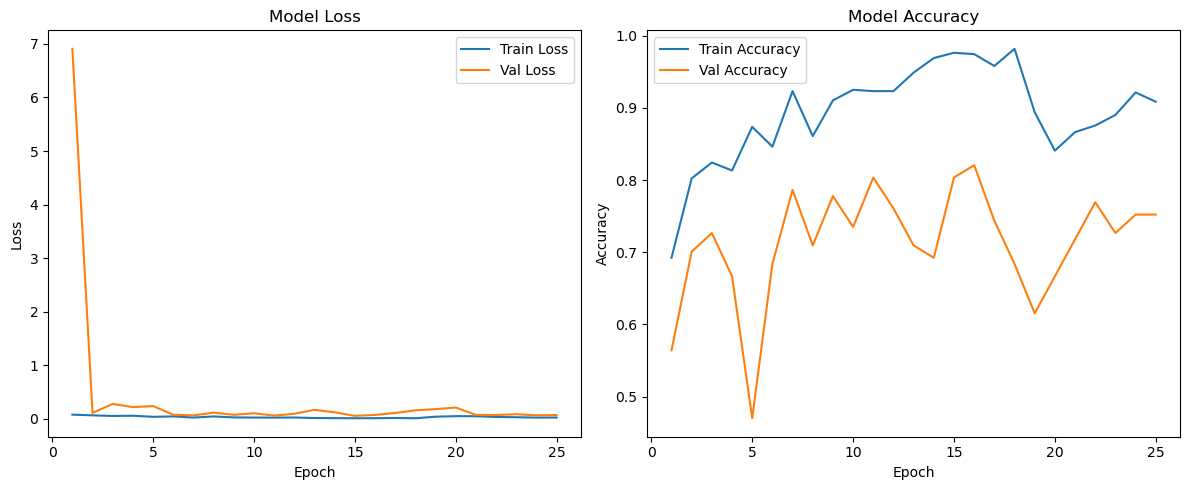

In [18]:
# Plot training and validation loss and accuracy from the training history

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate the model on test set

In [19]:
#  Evaluate the Model on the Test Set
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and labels
test_preds, test_labels = evaluate_model(model, dataloaders['test'])

# Calculate accuracy
test_acc = np.mean(test_preds == test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7458


# Show Report

              precision    recall  f1-score   support

      benign       0.78      0.80      0.79        66
   malignant       0.67      0.69      0.68        32
      normal       0.76      0.65      0.70        20

    accuracy                           0.75       118
   macro avg       0.74      0.71      0.72       118
weighted avg       0.75      0.75      0.75       118



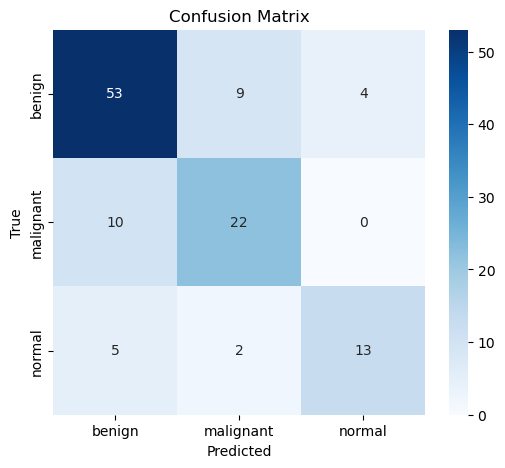

In [20]:
# Show a Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(test_labels, test_preds, target_names=train_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Sample some prediction 

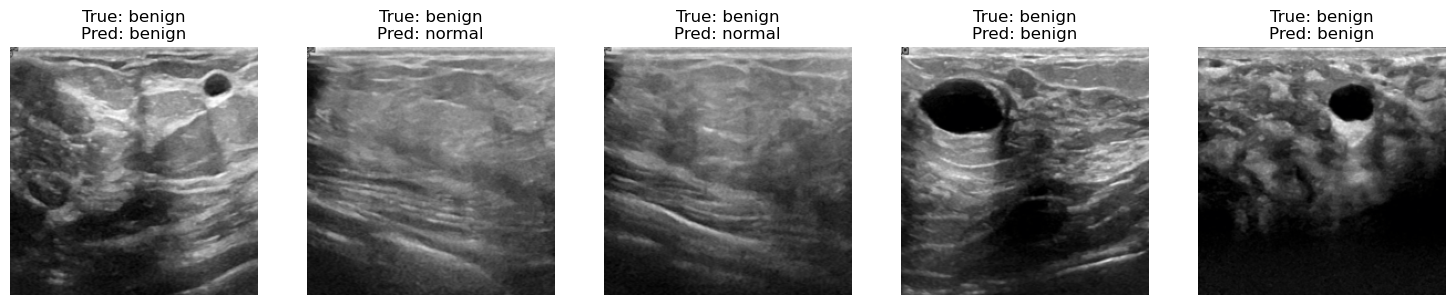

In [21]:
#Visualize Some Predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images_shown = 0
    class_names = dataloader.dataset.classes
    plt.figure(figsize=(15, 3))
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                img = inputs[i].cpu().numpy().transpose(1,2,0)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.subplot(1, num_images, images_shown+1)
                plt.imshow(img)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
                plt.axis('off')
                images_shown += 1

visualize_predictions(model, dataloaders['test'], num_images=5)

In [24]:
#Save the Model
torch.save(model.state_dict(), 'model_focal.pth')


To reduce missed malignant cases (i.e., **increase recall for the malignant class**), you can try these strategies:

---

### 1. **Class Weighting in Loss Function**
Give more importance to malignant cases during training:

````python
# Calculate class weights (inverse of class frequency, for example)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.targets),
    y=train_dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use in loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
````

---

### 2. **Data Augmentation for Malignant Class**
Increase the variety of malignant images:

- Use more aggressive augmentations (rotation, flip, contrast, etc.) for malignant samples.
- You can oversample malignant images in your training set.

---

### 3. **Oversampling**
Balance your dataset by duplicating malignant samples:

````python
from torch.utils.data import WeightedRandomSampler

targets = train_dataset.targets
class_sample_count = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in targets])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
````

---

### 4. **Threshold Tuning**
After training, adjust the decision threshold for the malignant class to favor recall (at the cost of precision).

---

### 5. **Monitor with Confusion Matrix**
Always check the confusion matrix to see if malignant cases are being confused with a specific other class.

---

### 6. **Try Focal Loss**
Focal loss focuses learning on hard-to-classify examples (like malignant):

````python
# pip install torch-focal
from torch_focal import FocalLoss
criterion = FocalLoss()
````

---

**Summary:**  
- Use class weighting or oversampling to handle class imbalance.
- Apply more data augmentation to malignant cases.
- Consider focal loss or threshold tuning.
- Always monitor recall and confusion matrix for malignant class.

Let me know if you want code for a specific method!

Similar code found with 1 license type

You are correct—your **normal** class is much smaller than the other classes:

- **malignant:** 210 images
- **benign:** 438 images
- **normal:** 133 images

This is called **class imbalance**.

---

### What does this mean?

- Your model will see far fewer normal images during training.
- It may learn to ignore the normal class or perform poorly on it (lower recall/precision).
- The model may be biased toward predicting benign or malignant, simply because it sees those more often.

---

### Why is this a problem?

- In medical imaging, missing normal cases (or over-predicting abnormal) can lead to unnecessary anxiety or missed diagnoses.
- Imbalanced data can hurt overall model performance and reliability.

---

### What can you do?

1. **Oversample the normal class**  
   - Duplicate normal images in the training set.
   - Use a `WeightedRandomSampler` in your DataLoader.

2. **Data augmentation**  
   - Apply more augmentation (rotations, flips, noise, etc.) to normal images to artificially increase their variety.

3. **Class weighting**  
   - Use class weights in your loss function to penalize mistakes on the normal class more.

4. **Collect more normal data** (if possible)  
   - The best solution is to get more normal images.

---

### Example: WeightedRandomSampler

````python
from torch.utils.data import WeightedRandomSampler
import numpy as np

targets = train_dataset.targets
class_sample_count = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in targets])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
````

---

**Summary:**  
- Your dataset is imbalanced, especially for the normal class.
- This can hurt model performance for that class.
- Use oversampling, augmentation, or class weighting to help balance training.

Let me know if you want code for a specific solution!

Similar code found with 1 license type

Use K-fold on Train set of find hyperparameter
📌 สำหรับ Neural Networks
- learning_rate → ความเร็วในการเรียนรู้
- batch_size → ขนาดของ batch
- num_layers, hidden_units → โครงสร้างของ network
- dropout_rate → อัตราการ dropou


1. Data Augmentation
Apply more aggressive augmentations (rotation, flip, brightness, contrast, noise) especially to minority classes (malignant, normal).
This helps the model generalize and reduces overfitting.
2. Handle Class Imbalance
WeightedRandomSampler: Use it in your DataLoader to oversample minority classes.
Class weights: You already use them in your loss function—keep this.
Synthetic data: Consider generating synthetic images for underrepresented classes.
3. Try Different Architectures
Experiment with other pre-trained models (EfficientNet, DenseNet, etc.) and compare results.
4. Fine-tune More Layers
Unfreeze more layers of ResNet50 (not just the final layer) and fine-tune with a lower learning rate.
5. Use Focal Loss
Focal loss helps focus learning on hard-to-classify (often minority) samples.
Install: pip install torch-focal
Usage:
6. Hyperparameter Tuning
Try different learning rates, batch sizes, optimizers (Adam, AdamW, SGD), and dropout rates.
7. Early Stopping
Stop training when validation loss stops improving to avoid overfitting.
8. Ensemble Methods
Train multiple models and average their predictions for better robustness.
9. Threshold Tuning
Adjust the decision threshold for the malignant class to increase recall (catch more true positives).
10. More Data
If possible, collect more images, especially for underrepresented classes.
Summary:
Focus on data augmentation, class balancing, fine-tuning, and loss function improvements.
Monitor recall for malignant cases and confusion matrix to guide your changes.